In [ ]:
!python --version

## tensorflow 风格迁移模型实现

In [1]:
!git clone https://github.com/davidADSP/GDL_code/

Cloning into 'GDL_code'...
remote: Enumerating objects: 394, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 394 (delta 0), reused 1 (delta 0), pack-reused 391
Receiving objects: 100% (394/394), 22.13 MiB | 18.17 MiB/s, done.
Resolving deltas: 100% (237/237), done.


In [2]:
cd /kaggle/working/GDL_code

/kaggle/working/GDL_code


In [3]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-m9t5zyk0
  Running setup.py bdist_wheel for keras-contrib ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-6j73y9w4/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
You are using pip version 18.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
from __future__ import print_function, division
import scipy

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.layers.merge import add
from models.layers.layers import ReflectionPadding2D
from keras.models import Sequential, Model
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras import backend as K

from keras.utils import plot_model

import datetime
import matplotlib.pyplot as plt
import sys

import numpy as np
import os
import pickle as pkl
import random

from collections import deque


class CycleGAN():
    def __init__(self
        , input_dim
        , learning_rate
        , lambda_validation
        , lambda_reconstr
        , lambda_id
        , generator_type
        , gen_n_filters
        , disc_n_filters
        , buffer_max_length = 50
        ):

        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.buffer_max_length = buffer_max_length
        self.lambda_validation = lambda_validation
        self.lambda_reconstr = lambda_reconstr
        self.lambda_id = lambda_id
        self.generator_type = generator_type
        self.gen_n_filters = gen_n_filters
        self.disc_n_filters = disc_n_filters

        # Input shape
        self.img_rows = input_dim[0]
        self.img_cols = input_dim[1]
        self.channels = input_dim[2]
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        self.d_losses = []
        self.g_losses = []
        self.epoch = 0

        self.buffer_A = deque(maxlen = self.buffer_max_length)
        self.buffer_B = deque(maxlen = self.buffer_max_length)
        
        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**3)
        self.disc_patch = (patch, patch, 1)

        self.weight_init = RandomNormal(mean=0., stddev=0.02)

        self.compile_models()

        
    def compile_models(self):

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        
        self.d_A.compile(loss='mse',
            optimizer=Adam(self.learning_rate, 0.5),
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=Adam(self.learning_rate, 0.5),
            metrics=['accuracy'])


        # Build the generators
        if self.generator_type == 'unet':
            self.g_AB = self.build_generator_unet()
            self.g_BA = self.build_generator_unet()
        else:
            self.g_AB = self.build_generator_resnet()
            self.g_BA = self.build_generator_resnet()

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  self.lambda_validation,                       self.lambda_validation,
                                            self.lambda_reconstr, self.lambda_reconstr,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=Adam(0.0002, 0.5))

        self.d_A.trainable = True
        self.d_B.trainable = True
    

    def build_generator_unet(self):

        def downsample(layer_input, filters, f_size=4):
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = InstanceNormalization(axis = -1, center = False, scale = False)(d)
            d = Activation('relu')(d)
            
            return d

        def upsample(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same')(u)
            u = InstanceNormalization(axis = -1, center = False, scale = False)(u)
            u = Activation('relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)

            u = Concatenate()([u, skip_input])
            return u

        # Image input
        img = Input(shape=self.img_shape)

        # Downsampling
        d1 = downsample(img, self.gen_n_filters) 
        d2 = downsample(d1, self.gen_n_filters*2)
        d3 = downsample(d2, self.gen_n_filters*4)
        d4 = downsample(d3, self.gen_n_filters*8)

        # Upsampling
        u1 = upsample(d4, d3, self.gen_n_filters*4)
        u2 = upsample(u1, d2, self.gen_n_filters*2)
        u3 = upsample(u2, d1, self.gen_n_filters)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

        return Model(img, output_img)


    def build_generator_resnet(self):

        def conv7s1(layer_input, filters, final):
            y = ReflectionPadding2D(padding =(3,3))(layer_input)
            y = Conv2D(filters, kernel_size=(7,7), strides=1, padding='valid', kernel_initializer = self.weight_init)(y)
            if final:
                y = Activation('tanh')(y)
            else:
                y = InstanceNormalization(axis = -1, center = False, scale = False)(y)
                y = Activation('relu')(y)
            return y

        def downsample(layer_input,filters):
            y = Conv2D(filters, kernel_size=(3,3), strides=2, padding='same', kernel_initializer = self.weight_init)(layer_input)
            y = InstanceNormalization(axis = -1, center = False, scale = False)(y)
            y = Activation('relu')(y)
            return y

        def residual(layer_input, filters):
            shortcut = layer_input
            y = ReflectionPadding2D(padding =(1,1))(layer_input)
            y = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='valid', kernel_initializer = self.weight_init)(y)
            y = InstanceNormalization(axis = -1, center = False, scale = False)(y)
            y = Activation('relu')(y)
            
            y = ReflectionPadding2D(padding =(1,1))(y)
            y = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='valid', kernel_initializer = self.weight_init)(y)
            y = InstanceNormalization(axis = -1, center = False, scale = False)(y)

            return add([shortcut, y])

        def upsample(layer_input,filters):
            y = Conv2DTranspose(filters, kernel_size=(3, 3), strides=2, padding='same', kernel_initializer = self.weight_init)(layer_input)
            y = InstanceNormalization(axis = -1, center = False, scale = False)(y)
            y = Activation('relu')(y)
    
            return y


        # Image input
        img = Input(shape=self.img_shape)

        y = img

        y = conv7s1(y, self.gen_n_filters, False)
        y = downsample(y, self.gen_n_filters * 2)
        y = downsample(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = upsample(y, self.gen_n_filters * 2)
        y = upsample(y, self.gen_n_filters)
        y = conv7s1(y, 3, True)
        output = y

   
        return Model(img, output)


    def build_discriminator(self):

        def conv4(layer_input,filters, stride = 2, norm=True):
            y = Conv2D(filters, kernel_size=(4,4), strides=stride, padding='same', kernel_initializer = self.weight_init)(layer_input)
            
            if norm:
                y = InstanceNormalization(axis = -1, center = False, scale = False)(y)

            y = LeakyReLU(0.2)(y)
           
            return y

        img = Input(shape=self.img_shape)

        y = conv4(img, self.disc_n_filters, stride = 2, norm = False)
        y = conv4(y, self.disc_n_filters*2, stride = 2)
        y = conv4(y, self.disc_n_filters*4, stride = 2)
        y = conv4(y, self.disc_n_filters*8, stride = 1)

        output = Conv2D(1, kernel_size=4, strides=1, padding='same',kernel_initializer = self.weight_init)(y)

        return Model(img, output)

    def train_discriminators(self, imgs_A, imgs_B, valid, fake):

        # Translate images to opposite domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)

        self.buffer_B.append(fake_B)
        self.buffer_A.append(fake_A)

        fake_A_rnd = random.sample(self.buffer_A, min(len(self.buffer_A), len(imgs_A)))
        fake_B_rnd = random.sample(self.buffer_B, min(len(self.buffer_B), len(imgs_B)))

        # Train the discriminators (original images = real / translated = Fake)
        dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
        dA_loss_fake = self.d_A.train_on_batch(fake_A_rnd, fake)
        dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

        dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
        dB_loss_fake = self.d_B.train_on_batch(fake_B_rnd, fake)
        dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

        # Total disciminator loss
        d_loss_total = 0.5 * np.add(dA_loss, dB_loss)

        return (
            d_loss_total[0]
            , dA_loss[0], dA_loss_real[0], dA_loss_fake[0]
            , dB_loss[0], dB_loss_real[0], dB_loss_fake[0]
            , d_loss_total[1]
            , dA_loss[1], dA_loss_real[1], dA_loss_fake[1]
            , dB_loss[1], dB_loss_real[1], dB_loss_fake[1]
        )

    def train_generators(self, imgs_A, imgs_B, valid):

        # Train the generators
        return self.combined.train_on_batch([imgs_A, imgs_B],
                                                [valid, valid,
                                                imgs_A, imgs_B,
                                                imgs_A, imgs_B])


    def train(self, data_loader, run_folder, epochs, test_A_file, test_B_file, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(self.epoch, epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(data_loader.load_batch()):

                d_loss = self.train_discriminators(imgs_A, imgs_B, valid, fake)
                g_loss = self.train_generators(imgs_A, imgs_B, valid)

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                    % ( self.epoch, epochs,
                        batch_i, data_loader.n_batches,
                        d_loss[0], 100*d_loss[7],
                        g_loss[0],
                        np.sum(g_loss[1:3]),
                        np.sum(g_loss[3:5]),
                        np.sum(g_loss[5:7]),
                        elapsed_time))

                self.d_losses.append(d_loss)
                self.g_losses.append(g_loss)

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(data_loader, batch_i, run_folder, test_A_file, test_B_file)
                    self.combined.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (self.epoch)))
                    self.combined.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                    self.save_model(run_folder)

                
            self.epoch += 1

    def sample_images(self, data_loader, batch_i, run_folder, test_A_file, test_B_file):
        
        r, c = 2, 4

        for p in range(2):

            if p == 1:
                imgs_A = data_loader.load_data(domain="A", batch_size=1, is_testing=True)
                imgs_B = data_loader.load_data(domain="B", batch_size=1, is_testing=True)
            else:
                imgs_A = data_loader.load_img('data/%s/testA/%s' % (data_loader.dataset_name, test_A_file))
                imgs_B = data_loader.load_img('data/%s/testB/%s' % (data_loader.dataset_name, test_B_file))

            # Translate images to the other domain
            fake_B = self.g_AB.predict(imgs_A)
            fake_A = self.g_BA.predict(imgs_B)
            # Translate back to original domain
            reconstr_A = self.g_BA.predict(fake_B)
            reconstr_B = self.g_AB.predict(fake_A)

            # ID the images
            id_A = self.g_BA.predict(imgs_A)
            id_B = self.g_AB.predict(imgs_B)

            gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, id_A, imgs_B, fake_A, reconstr_B, id_B])

            # Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5
            gen_imgs = np.clip(gen_imgs, 0, 1)

            titles = ['Original', 'Translated', 'Reconstructed', 'ID']
            fig, axs = plt.subplots(r, c, figsize=(25,12.5))
            cnt = 0
            for i in range(r):
                for j in range(c):
                    axs[i,j].imshow(gen_imgs[cnt])
                    axs[i, j].set_title(titles[j])
                    axs[i,j].axis('off')
                    cnt += 1
            fig.savefig(os.path.join(run_folder ,"images/%d_%d_%d.png" % (p, self.epoch, batch_i)))
            plt.close()


    def plot_model(self, run_folder):
        plot_model(self.combined, to_file=os.path.join(run_folder ,'viz/combined.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.d_A, to_file=os.path.join(run_folder ,'viz/d_A.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.d_B, to_file=os.path.join(run_folder ,'viz/d_B.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.g_BA, to_file=os.path.join(run_folder ,'viz/g_BA.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.g_AB, to_file=os.path.join(run_folder ,'viz/g_AB.png'), show_shapes = True, show_layer_names = True)


    def save(self, folder):

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pkl.dump([
                self.input_dim
                ,  self.learning_rate
                ,  self.buffer_max_length
                ,  self.lambda_validation
                ,  self.lambda_reconstr
                ,  self.lambda_id
                ,  self.generator_type
                ,  self.gen_n_filters
                ,  self.disc_n_filters
                ], f)

        self.plot_model(folder)


    def save_model(self, run_folder):


        self.combined.save(os.path.join(run_folder, 'model.h5')  )
        self.d_A.save(os.path.join(run_folder, 'd_A.h5') )
        self.d_B.save(os.path.join(run_folder, 'd_B.h5') )
        self.g_BA.save(os.path.join(run_folder, 'g_BA.h5')  )
        self.g_AB.save(os.path.join(run_folder, 'g_AB.h5') )

        pkl.dump(self, open( os.path.join(run_folder, "obj.pkl"), "wb" ))

    def load_weights(self, filepath):
        self.combined.load_weights(filepath)


Using TensorFlow backend.


In [5]:
import os
import matplotlib.pyplot as plt
from glob import glob

In [6]:

# run params
SECTION = 'paint'
RUN_ID = '0001'
DATA_NAME = 'apple2orange'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' # 'build' # 

In [7]:
IMAGE_SIZE = 128

In [30]:

data_loader = DataLoader(dataset_name='/kaggle/input/monet2photo/monet2photo', img_res=(IMAGE_SIZE, IMAGE_SIZE))


In [8]:
gan = CycleGAN(
    input_dim = (IMAGE_SIZE,IMAGE_SIZE,3)
    ,learning_rate = 0.0002
    , buffer_max_length = 50
    , lambda_validation = 1
    , lambda_reconstr = 10
    , lambda_id = 2
    , generator_type = 'unet'
    , gen_n_filters = 32
    , disc_n_filters = 32
    )

if mode == 'build':
    gan.save(RUN_FOLDER)
else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))
    


In [9]:
gan.g_BA.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 64, 64, 32)   1568        input_4[0][0]                    
__________________________________________________________________________________________________
instance_normalization_14 (Inst (None, 64, 64, 32)   0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 64, 64, 32)   0           instance_normalization_14[0][0]  
__________________________________________________________________________________________________
conv2d_20 

In [10]:
gan.d_A.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        1568      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        32832     
_________________________________________________________________
instance_normalization_1 (In (None, 32, 32, 64)        0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       131200    
__________

## pytorch

In [2]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import models,transforms

import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models,transforms

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)



In [3]:
def make_datapath_list(root_path):
    """
    Returns:
    -----------
    path_list:list
    保存数据路径的列表
    """
    #root_path='/kaggle/input/celebrity-face-image-dataset/Celebrity Faces Dataset'
    target_path=osp.join(root_path+'/*.jpg')

    return glob.glob(target_path)

pathA='/kaggle/input/monet2photo/monet2photo/trainA'
pathB='/kaggle/input/monet2photo/monet2photo/trainB'
imagesA=make_datapath_list(pathA)
imagesB=make_datapath_list(pathB)

images_num=min(len(imagesA),len(imagesB))
images_num

1072

In [4]:
test_num=int(images_num*0.1)
train_listA=imagesA[test_num:]
test_listA=imagesA[:test_num]
train_listB=imagesB[test_num:]
test_listB=imagesB[:test_num]
train_listA[:5]

['/kaggle/input/monet2photo/monet2photo/trainA/766.jpg',
 '/kaggle/input/monet2photo/monet2photo/trainA/85.jpg',
 '/kaggle/input/monet2photo/monet2photo/trainA/564.jpg',
 '/kaggle/input/monet2photo/monet2photo/trainA/359.jpg',
 '/kaggle/input/monet2photo/monet2photo/trainA/67.jpg']

In [62]:
class MyDataset(data.Dataset):
    def __init__(self,file_list,transform=None,phase='train'):
        self.file_list=file_list
        self.transform=transform
        self.phase=phase
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self,index):
        image_path=self.file_list[index]
        img=Image.open(image_path)
        img_transformed=self.transform(img)
        
        return img_transformed
    
Image_size=128

transform=transforms.Compose([
    transforms.Resize(int(Image_size*1.12)),
    transforms.RandomCrop((Image_size,Image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5, 0.5),(0.5, 0.5, 0.5))
])

trainA_dataset=MyDataset(train_listA,transform,'train')
trainB_dataset=MyDataset(train_listB,transform,'train')
print(len(trainB_dataset))
print(trainA_dataset.__getitem__(1))

6180
tensor([[[-0.3882, -0.4275, -0.4431,  ..., -0.4667, -0.2314,  0.1922],
         [-0.4275, -0.4118, -0.3882,  ..., -0.8039, -0.6314, -0.3961],
         [-0.4745, -0.3882, -0.3333,  ..., -0.1216, -0.0667, -0.0353],
         ...,
         [-0.4980, -0.4980, -0.4431,  ..., -0.6000, -0.6941, -0.7725],
         [-0.5922, -0.6471, -0.5608,  ..., -0.6471, -0.8039, -0.8275],
         [-0.5529, -0.5843, -0.6392,  ..., -0.7098, -0.7647, -0.8039]],

        [[-0.2078, -0.2706, -0.2706,  ..., -0.1137, -0.1373, -0.1059],
         [-0.2392, -0.2627, -0.2549,  ..., -0.1294, -0.0902, -0.0196],
         [-0.2627, -0.2471, -0.2078,  ...,  0.0431,  0.0824,  0.0745],
         ...,
         [-0.2235, -0.2392, -0.2157,  ..., -0.2314, -0.3020, -0.2941],
         [-0.3020, -0.3804, -0.3020,  ..., -0.1765, -0.3098, -0.2627],
         [-0.2941, -0.3098, -0.3333,  ..., -0.1922, -0.2392, -0.2157]],

        [[-0.3176, -0.3647, -0.3412,  ..., -0.3020, -0.2000, -0.0431],
         [-0.3490, -0.3569, -0.3255,  ..

In [6]:
batch_size=32
trainA_dataloader=torch.utils.data.DataLoader(trainA_dataset,batch_size=batch_size,shuffle=True)
trainB_dataloader=torch.utils.data.DataLoader(trainB_dataset,batch_size=batch_size,shuffle=False)
dataloaders_dict={
    'A':trainA_dataset,
    'B':trainB_dataset
}

batch_iter=iter(dataloaders_dict['A'])#转成迭代器
inputs=next(batch_iter)#取第一个元素
print(inputs.size())

torch.Size([3, 128, 128])


In [4]:
from torch import nn
import torch
class block(nn.Module):
    def __init__(self,c_in,c_out,stride,norm=True):
        super().__init__()
        self.block=nn.Sequential(
            nn.Conv2d(c_in,c_out,kernel_size=(4,4),stride=stride,padding=(4-stride+1)//2)
        )
        if norm:
            self.block.add_module('Norm',nn.InstanceNorm2d(c_out))
        self.block.add_module('relu',nn.LeakyReLU(0.2))
    def forward(self,x):
        return self.block(x)
class Discriminator(nn.Module):
    def __init__(self,d_channels):
        super().__init__()
        self.D=nn.Sequential(
            block(3,d_channels,2,False),
            block(d_channels,d_channels*2,2),
            block(d_channels*2,d_channels*4,2),
            block(d_channels*4,d_channels*8,1),
            nn.Conv2d(d_channels*8,1,kernel_size=4,stride=1,padding=1)
        )
        #输出为16*16，预测每一块为真的概率
    def forward(self,x):
        return self.D(x)
d=Discriminator(32)
d(torch.zeros((64,3,128,128))).shape

torch.Size([64, 1, 16, 16])

In [5]:
class Generator(nn.Module):
    def __init__(self,g_channels):
        super().__init__()
        self.downSample_layers=[]
        self.out=[]
        self.d1=self.down_sample(3,g_channels)
        self.d2=self.down_sample(g_channels,g_channels*2)
        self.d3=self.down_sample(g_channels*2,g_channels*4)
        self.d4=self.down_sample(g_channels*4,g_channels*8)
        self.u1=self.up_sample(g_channels*8,g_channels*4)
        self.u2=self.up_sample(g_channels*4+g_channels*4,g_channels*2)
        self.u3=self.up_sample(g_channels*2+g_channels*2,g_channels*1)
        self.u4=nn.Upsample(scale_factor=2)
        self.output=nn.Conv2d(g_channels+g_channels,3,kernel_size=3,stride=1,padding=(4-1)//2)
        self.layers=nn.ModuleList([self.d1,self.d2,self.d3,self.d4]+[self.u1,self.u2,self.u3,self.u4,self.output])
        
    def down_sample(self,in_c,out_c,kernel_size=3,stride=2):
        return nn.Sequential(
            nn.Conv2d(in_c,out_c,kernel_size,stride,1),
            nn.InstanceNorm2d(out_c),
            nn.ReLU()
        )
    def up_sample(self,in_c,out_c,kernel_size=3,stride=1,dropout_rate=0):
        block=nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_c,out_c,kernel_size,stride,(kernel_size-stride)//2),
            nn.InstanceNorm2d(out_c,1),
            nn.ReLU(),
            #nn.Dropout(dropout_rate) if dropout_rate ,
            
        )
        if dropout_rate:
            block.add_module('dropout',nn.Dropout(dropout_rate))
        return block
    def forward(self,x):
        out1=self.d1(x)
        out2=self.d2(out1)
        out3=self.d3(out2)
        out4=self.d4(out3)
        x=self.u1(out4)
        x=torch.cat([x,out3],1)
        x=self.u2(x)
        x=torch.cat([x,out2],1)
        x=self.u3(x)
        x=torch.cat([x,out1],1)
        x=self.u4(x)
        x=self.output(x)
        x=nn.Tanh()(x)
        return x
g=Generator(32)
g(torch.zeros((64,3,128,128))).shape

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


torch.Size([64, 3, 128, 128])

In [112]:
from torchsummary import summary
summary(d,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,568
         LeakyReLU-2           [-1, 32, 64, 64]               0
             block-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          32,832
    InstanceNorm2d-5           [-1, 64, 32, 32]               0
         LeakyReLU-6           [-1, 64, 32, 32]               0
             block-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 16, 16]         131,200
    InstanceNorm2d-9          [-1, 128, 16, 16]               0
        LeakyReLU-10          [-1, 128, 16, 16]               0
            block-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 256, 17, 17]         524,544
   InstanceNorm2d-13          [-1, 256, 17, 17]               0
        LeakyReLU-14          [-1, 256,

In [63]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
learning_rate=0.0002
hidden_G=32
hidden_D=32
Epochs=200

In [67]:
#定义模型
import itertools
D_A=Discriminator(hidden_D).to(device)
D_B=Discriminator(hidden_D).to(device)
G_AB=Generator(hidden_G).to(device)
G_BA=Generator(hidden_G).to(device)

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=learning_rate, betas=(0.5, 0.999)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [68]:
#定义loss
MSE = nn.MSELoss().cuda()
L1 = nn.L1Loss().cuda()
criterion_identity = nn.L1Loss().cuda()

epochs:199


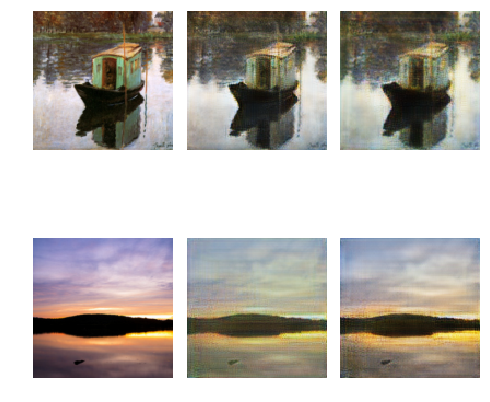








21it [00:13,  1.45it/s]






22it [00:13,  1.51it/s]






23it [00:14,  1.58it/s]






24it [00:14,  1.63it/s]






25it [00:15,  1.66it/s]






26it [00:16,  1.69it/s]






27it [00:16,  1.72it/s]






28it [00:17,  1.76it/s]






29it [00:17,  1.77it/s]






30it [00:18,  1.78it/s]












100%|██████████| 200/200 [1:01:53<00:00, 18.36s/it]







In [70]:
from IPython.display import clear_output
from tqdm import tqdm
#训练
from torch.autograd import Variable
Tensor = torch.cuda.FloatTensor 
D_output_shape=(1,16,16)
c=0
for i in tqdm(range(Epochs)):
    trainA_dataloader=torch.utils.data.DataLoader(trainA_dataset,batch_size=batch_size,shuffle=True,drop_last=True)
    trainB_dataloader=torch.utils.data.DataLoader(trainB_dataset,batch_size=batch_size,shuffle=True,drop_last=True)
    cnt=0
    for img_A,img_B in tqdm(zip(trainA_dataloader,trainB_dataloader)):
        if cnt>30:
            break
        real_A=img_A.to(device)
        real_B=img_B.to(device)
        vaild = Variable(Tensor(np.ones((real_A.size(0), *D_output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_output_shape))), requires_grad=False)
        
        #训练生成器
        G_AB.train()
        G_BA.train()
        optimizer_G.zero_grad()
        
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)

        loss_identity = (loss_id_A + loss_id_B) / 2
        
        fake_B=G_AB(real_A)
        fake_A=G_BA(real_B)
        loss_GAN_BA=MSE(D_A(fake_A),vaild)
        loss_GAN_AB=MSE(D_B(fake_B),vaild)
        
        loss_GAN=(loss_GAN_AB+loss_GAN_BA)/2
        reconv_A=G_BA(fake_B)
        reconv_B=G_AB(fake_A)
        loss_cycle_A=L1(reconv_A,real_A)
        loss_cycle_B=L1(reconv_B,real_B)
        
        loss_cycle=(loss_cycle_A+loss_cycle_B)/2
        
        loss_G=loss_GAN+loss_cycle*10+loss_identity*5
        loss_G.backward()
        optimizer_G.step()
        
        ## 训练判别器A
        optimizer_D_A.zero_grad()
        
        loss_real=MSE(D_A(real_A),vaild)
        loss_fake=MSE(D_A(fake_A.detach()),fake)
        loss_D_A=(loss_real+loss_fake)/2
        
        loss_D_A.backward()
        optimizer_D_A.step()
        
        ## 训练判别器B
        optimizer_D_B.zero_grad()
        
        loss_real=MSE(D_B(real_B),vaild)
        loss_fake=MSE(D_B(fake_B.detach()),fake)
        loss_D_B=(loss_real+loss_fake)/2
        
        loss_D_B.backward()
        optimizer_D_B.step()
        
        if cnt %10==0:
            clear_output()
            print('epochs:{}'.format(i))
            with torch.no_grad():
                fig = plt.figure(figsize=(8,8))
                fig.subplots_adjust(hspace=0.1, wspace=0.1)
                imgA_list=[real_A[0],fake_B[0],reconv_A[0]]
                imgB_list=[real_B[0],fake_A[0],reconv_B[0]]
                for j in range(3):
                    img=imgA_list[j]
                    sub = fig.add_subplot(2, 3, j+1)
                    sub.axis('off')        
                    sub.imshow((img*0.5+0.5).detach().cpu().numpy().transpose((1,2,0)))
                for j in range(3):
                    img=imgB_list[j]
                    sub = fig.add_subplot(2, 3, j+3+1)
                    sub.axis('off')        
                    sub.imshow((img*0.5+0.5).detach().cpu().numpy().transpose((1,2,0)))
                plt.show()
        cnt+=1
        c+=1
        
    



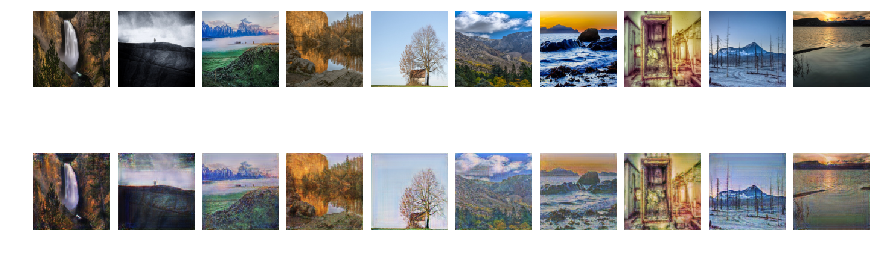

In [81]:
trainA_dataloader=torch.utils.data.DataLoader(trainA_dataset,batch_size=batch_size,shuffle=False)
trainB_dataloader=torch.utils.data.DataLoader(trainB_dataset,batch_size=batch_size,shuffle=False)
img_A=next(iter(trainA_dataloader))
img_B=next(iter(trainB_dataloader))
real_A=Variable(img_A.type(Tensor))
real_B=Variable(img_B.type(Tensor))
fake_A=G_AB(real_A)
fake_B=G_BA(real_B)
n_to_show =10
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)


for i in range(n_to_show):
    img = real_B[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow((img*0.5+0.5).detach().cpu().numpy().transpose(1,2,0))

for i in range(n_to_show):
    img = fake_B[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow((img*0.5+0.5).detach().cpu().numpy().transpose(1,2,0))
fig.savefig('photo2Monet.png')


## horse2zebra

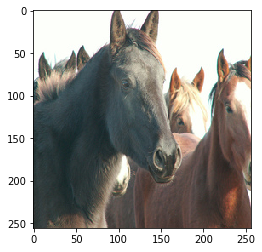

In [87]:
path='/kaggle/input/horse2zebra/horse2zebra/trainA/n02381460_1001.jpg'
img=plt.imread(path)
plt.imshow(img)

In [6]:
pathA='/kaggle/input/horse2zebra/horse2zebra/trainA'
pathB='/kaggle/input/horse2zebra/horse2zebra/trainB'
imagesA=make_datapath_list(pathA)
imagesB=make_datapath_list(pathB)
print(imagesA[:5])
num=min(len(imagesA),len(imagesB))
train_listA=imagesA[:num]
train_listB=imagesB[:num]

class MyDataset(data.Dataset):
    def __init__(self,file_list,transform=None,phase='train'):
        self.file_list=file_list
        self.transform=transform
        self.phase=phase
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self,index):
        image_path=self.file_list[index]
        img=Image.open(image_path)
        img = img.convert('RGB')#单通道转三通道
        img_transformed=self.transform(img)
        return img_transformed
    
Image_size=128

transform=transforms.Compose([
    transforms.Resize((int(Image_size*1.12),int(Image_size*1.12))),
    transforms.RandomCrop((Image_size,Image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5, 0.5),(0.5, 0.5, 0.5))
])
trainA_dataset=MyDataset(train_listA,transform,'train')
trainB_dataset=MyDataset(train_listB,transform,'train')

['/kaggle/input/horse2zebra/horse2zebra/trainA/n02381460_4625.jpg', '/kaggle/input/horse2zebra/horse2zebra/trainA/n02381460_1204.jpg', '/kaggle/input/horse2zebra/horse2zebra/trainA/n02381460_1674.jpg', '/kaggle/input/horse2zebra/horse2zebra/trainA/n02381460_2444.jpg', '/kaggle/input/horse2zebra/horse2zebra/trainA/n02381460_7692.jpg']


In [11]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
learning_rate=0.0005
hidden_G=32
hidden_D=32
Epochs=100

#定义模型
import itertools
D_A=Discriminator(hidden_D).to(device)
D_B=Discriminator(hidden_D).to(device)
G_AB=Generator(hidden_G).to(device)
G_BA=Generator(hidden_G).to(device)

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=learning_rate, betas=(0.5, 0.999)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=learning_rate, betas=(0.5, 0.999))

#定义loss
MSE = nn.MSELoss().cuda()
L1 = nn.L1Loss().cuda()
criterion_identity = nn.L1Loss().cuda()

epochs:59
0.4028460383415222 0.18770907819271088 0.15657120943069458 0.20359022915363312 0.20480874180793762


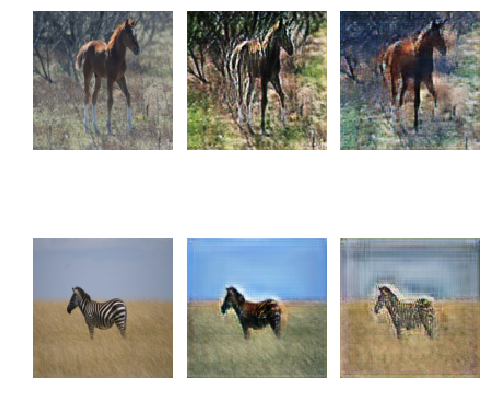







































































21it [00:14,  1.27it/s]





































































22it [00:14,  1.38it/s]





































































23it [00:15,  1.46it/s]





































































24it [00:15,  1.49it/s]





































































25it [00:16,  1.52it/s]





































































26it [00:17,  1.55it/s]





































































27it [00:17,  1.59it/s]





































































28it [00:18,  1.62it/s]

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm
#训练
from torch.autograd import Variable
Tensor = torch.cuda.FloatTensor 
D_output_shape=(1,16,16)
c=0
for i in range(Epochs):
    trainA_dataloader=torch.utils.data.DataLoader(trainA_dataset,batch_size=batch_size,shuffle=True,drop_last=True)
    trainB_dataloader=torch.utils.data.DataLoader(trainB_dataset,batch_size=batch_size,shuffle=True,drop_last=True)
    cnt=0
    for img_A,img_B in tqdm(zip(trainA_dataloader,trainB_dataloader)):
        if cnt>30:
            break
        real_A=img_A.to(device)
        real_B=img_B.to(device)
        vaild = Variable(Tensor(np.ones((real_A.size(0), *D_output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_output_shape))), requires_grad=False)
        fake_B=G_AB(real_A)
        fake_A=G_BA(real_B)
        
        #if cnt%3==0:
            
        ## 训练判别器A
        optimizer_D_A.zero_grad()

        loss_real=MSE(D_A(real_A),vaild)
        loss_fake=MSE(D_A(fake_A.detach()),fake)
        loss_D_A=(loss_real+loss_fake)/2

        loss_D_A.backward()
        optimizer_D_A.step()

        ## 训练判别器B
        optimizer_D_B.zero_grad()

        loss_real=MSE(D_B(real_B),vaild)
        loss_fake=MSE(D_B(fake_B.detach()),fake)
        loss_D_B=(loss_real+loss_fake)/2

        loss_D_B.backward()
        optimizer_D_B.step()
        
        #训练生成器
        G_AB.train()
        G_BA.train()
        optimizer_G.zero_grad()
        
        
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)

        loss_identity = (loss_id_A + loss_id_B) / 2
        
        fake_B=G_AB(real_A)
        fake_A=G_BA(real_B)
        loss_GAN_BA=MSE(D_A(fake_A),vaild)
        loss_GAN_AB=MSE(D_B(fake_B),vaild)
        
        loss_GAN=(loss_GAN_AB*1.2+loss_GAN_BA)/2
        reconv_A=G_BA(fake_B)
        reconv_B=G_AB(fake_A)
        loss_cycle_A=L1(reconv_A,real_A)
        loss_cycle_B=L1(reconv_B,real_B)
        
        loss_cycle=(loss_cycle_A+loss_cycle_B)/2
        
        loss_G=loss_GAN*1.5+loss_cycle+loss_identity
        
        loss_G.backward()
        optimizer_G.step()
        
        
        
        if cnt %10==0:
            clear_output()
            print('epochs:{}'.format(i))
            print(loss_GAN.item(),loss_cycle.item(),loss_identity.item(),loss_D_A.item(),loss_D_B.item())
            with torch.no_grad():
                fig = plt.figure(figsize=(8,8))
                fig.subplots_adjust(hspace=0.1, wspace=0.1)
                imgA_list=[real_A[0],fake_B[0],reconv_A[0]]
                imgB_list=[real_B[0],fake_A[0],reconv_B[0]]
                for j in range(3):
                    img=imgA_list[j]
                    sub = fig.add_subplot(2, 3, j+1)
                    sub.axis('off')        
                    sub.imshow((img*0.5+0.5).detach().cpu().numpy().transpose((1,2,0)))
                for j in range(3):
                    img=imgB_list[j]
                    sub = fig.add_subplot(2, 3, j+3+1)
                    sub.axis('off')        
                    sub.imshow((img*0.5+0.5).detach().cpu().numpy().transpose((1,2,0)))
                plt.show()
        cnt+=1
        c+=1
        
    

